# Support Vector Machine

In [1]:
# file path exist
import os.path
from os import path

# translator
import googletrans
from googletrans import Translator

# pandas
import pandas as pd

# preprocessing of text
import re
import string
import nltk

# word tokenizer by nltk
from nltk import word_tokenize

# lemmatizer
from nltk.stem import WordNetLemmatizer

# stopwords (Remove buzz words)
from nltk.corpus import stopwords

# split data into train and test
from sklearn.model_selection import train_test_split

# bag of words
from sklearn.feature_extraction.text import CountVectorizer

# TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer

# RFM classifier from scikit learn
from sklearn.svm import LinearSVC

# Tf-idf feature extraction 
from sklearn.feature_extraction.text import TfidfVectorizer

# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# cross validation for kfold
from sklearn.model_selection import cross_val_score

# calc accuracy
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 

In [2]:
filename  = '../Data/Real and fake news/news'
df = pd.read_csv(filename + '.csv',  
               delimiter=',')
df.drop(df.columns[[0,1]], axis = 1, inplace = True)
# orig_df.columns = ['Text', 'Label']
df = df.replace(to_replace=['FAKE', 'REAL'], value=[0, 1])

In [3]:
# Run only for English data 
df["text"] = df["text"].astype(str)
df["label"] = df["label"].astype(str)

In [4]:
df.head()

,text,label
0,"Daniel Greenfield, a Shillman Journalism Fello...",0
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,0
2,U.S. Secretary of State John F. Kerry said Mon...,1
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",0
4,It's primary day in New York and front-runners...,1


### Class count

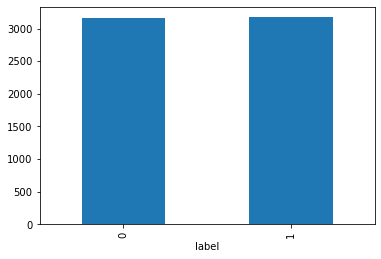

In [5]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6,4))
df.groupby('label').text.count().plot.bar(ylim=0)
plt.show()

In [6]:
# For entire dataset sentences for each labels 
df.label.value_counts()

1    3171
0    3164
Name: label, dtype: int64

In [7]:
#balancing data 
from collections import Counter
import numpy as np
def balanceClasses(xs, ys):
    item = {}
    new_ys = []
    new_xs = []
    #"""Undersample xs, ys to balance classes."""
    freqs = Counter(ys)
    # the most common class  is the maximum number we want for all classes
    max_allowable = (freqs.most_common()[0][1])
    
    for val in freqs.most_common(): # List
        nums = np.random.randint(1000)
        i = 1
        item[val[0]] = max_allowable - val[1]
        
        if item[val[0]] > 0:            
            while(item[val[0]] - i != 0): 
                nums = nums + 1
                if ys[nums] == val[0]:
                    i += 1
                    new_ys.append(ys[nums])
                    new_xs.append(xs[nums])
    return new_xs, new_ys

In [8]:
new_text, new_label = balanceClasses(df['text'], df['label'])

In [9]:
data = pd.DataFrame(new_text)
data.columns = ['text']
data['label'] = new_label
data = pd.concat([df, data])

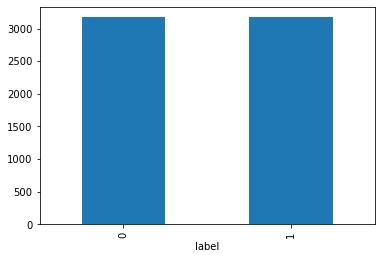

In [10]:
fig1 = plt.figure(figsize=(6,4))
data.groupby('label').text.count().plot.bar(ylim=0)
plt.show()

In [11]:
data.label.value_counts()

1    3171
0    3170
Name: label, dtype: int64

In [12]:
data=data.sample(frac=1).reset_index(drop=True)
data

,text,label
0,EDITOR’s NOTE: This story was originally publi...,1
1,The man behind the Trump rally disturbance in ...,0
2,"""One should not insist on nailing [Trump] into...",1
3,"by Yves Smith \nYves here. Even by the normal,...",0
4,The revival of middle-class jobs has been one ...,1
...,...,...
6336,"3454 Views November 07, 2016 15 Comments Guest...",0
6337,Arizona will become the first state in the nat...,1
6338,The families of 17 service members who died fi...,1
6339,A top U.S. military commander warned that Russ...,1


### Data Preprocessing

In [13]:
# People usually join sentences using more than one colon 

def ReplaceDoubleColon(inputString):
    return inputString.replace("..", " ") 

data['text'] = data['text'].apply(lambda x: ReplaceDoubleColon(x))

def ReplaceTripleColon(inputString):
    return inputString.replace("...", " ") 

data['text'] = data['text'].apply(lambda x: ReplaceTripleColon(x))

def ReplaceFourColon(inputString):
    return inputString.replace("....", " ") 

data['text'] = data['text'].apply(lambda x: ReplaceFourColon(x))

In [14]:
def textPattern(text):

    # Clean the text
    text = re.sub(r"@", " ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", "have", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"aren't", "are not", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"didn't", "did not", text)
    text = re.sub(r"doesn't", "does not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"hadn't", "had not", text)
    text = re.sub(r"hasn't", "has not", text)
    text = re.sub(r"haven't", "have not", text)
    text = re.sub(r"isn't", "is not", text)
    text = re.sub(r"shouldn't", "should not", text)
    text = re.sub(r"wasn't", "was not", text)
    text = re.sub(r"weren't", "were not", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"wouldn't", "would not", text)
    text = re.sub(r"mustn't", "must not", text)
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"\'re", "are", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\= =", " ", text)
    text = re.sub(r"\==", " ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"\s{2,}", " ", text)
    return text

data['text'] = data['text'].apply(lambda x: textPattern(x))

In [15]:
# Word Tokenization
tokens = [word_tokenize(sen) for sen in data.text]

In [16]:
# Lower Case
def lower_token(tokens): 
    return [w.lower() for w in tokens]    
    
lower_tokens = [lower_token(token) for token in tokens]

In [17]:
# Remove Link

def removeLink(token):
    word = []
    for w in token:
        if not w.startswith('http'):
            word.append(w)
    return word 
    
removedLink_tokens = [removeLink(token) for token in lower_tokens]

In [18]:
# Word Lemmatization
def lemmatization(token):
    return [lemmatizer.lemmatize(w) for w in token] 

lemmatizer = WordNetLemmatizer()

lemmatized_tokens = [lemmatization(token) for token in removedLink_tokens]

In [19]:
# Removing Stopwords
stoplist = stopwords.words('english')

In [20]:
def removeStopWords(tokens): 
    return [word for word in tokens if word not in stoplist]

filtered_words = [sen for sen in lemmatized_tokens]
data['Text_Final'] = [' '.join(sen) for sen in filtered_words]
data['tokens'] = filtered_words

In [21]:
zero  = []
one = []
for l in data.label:
    
    if l == '0':
        zero.append(1)
        one.append(0)
    elif l == '1':
        zero.append(0)
        one.append(1)

        
data['0']= zero
data['1']= one

data = data[['Text_Final', 'tokens', 'label', '0', '1']]

In [22]:
category_id = []
for l in data.label:
    
    if l == '0':
        category_id.append('0')
    elif l == '1':
        category_id.append('1')
        
data['Category_id'] = category_id

data = data[['Text_Final', 'tokens', 'label', '0', '1', 'Category_id' ]]
data.head(25)

,Text_Final,tokens,label,0,1,Category_id
0,editor ’ s note : this story wa originally pub...,"[editor, ’, s, note, :, this, story, wa, origi...",1,0,1,1
1,the man behind the trump rally disturbance in ...,"[the, man, behind, the, trump, rally, disturba...",0,1,0,0
2,`` one should not insist on nailing [ trump ] ...,"[``, one, should, not, insist, on, nailing, [,...",1,0,1,1
3,by yves smith yves here even by the normal a i...,"[by, yves, smith, yves, here, even, by, the, n...",0,1,0,0
4,the revival of middle - class job ha been one ...,"[the, revival, of, middle, -, class, job, ha, ...",1,0,1,1
5,iran is encouraging it terror ally to pursue t...,"[iran, is, encouraging, it, terror, ally, to, ...",1,0,1,1
6,nation put 2016 election into perspective by r...,"[nation, put, 2016, election, into, perspectiv...",0,1,0,0
7,notify me of follow - up comment by email noti...,"[notify, me, of, follow, -, up, comment, by, e...",0,1,0,0
8,donald trump s proposal to ban all muslim from...,"[donald, trump, s, proposal, to, ban, all, mus...",1,0,1,1
9,in a speech wednesday outlining his would - be...,"[in, a, speech, wednesday, outlining, his, wou...",1,0,1,1


In [23]:
data = data[data.tokens != '']

In [24]:
from io import StringIO
category_id_df = data[['label', 'Category_id']].drop_duplicates().sort_values('Category_id')
category_to_label_dict = dict(category_id_df.values)
label_to_category_dict = dict(category_id_df[['Category_id', 'label']].values)

#### Split Data into test and train
We will use 90 % data for training and 10 % for testing. We use random state so every time we get the same training and testing data.

# Support Vector Method (SVM) and Random Forest Method (RFM)

We referred a blog on Multi class classification for SVM and RFM [2]

### Generating features using TF-IDF Vectorizer method

In [25]:
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=2, norm='l2', encoding='latin-1', ngram_range=(1, 3), stop_words='english')
features = vectorizer.fit_transform(data.Text_Final).toarray()
labels = data.label
features.shape

(6341, 496294)

### Spliting data 90/ 10

In [26]:
# Using similar split as CNN model
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(features, labels, data.index, test_size=0.10, random_state=82)

### SVM - Generating model 

In [27]:
# generate Linear SVM model
model = LinearSVC()
clf = model.fit(X_train, y_train)
y_pred = model.predict(X_test)

###  SVM - Displaying false-positive rate (FPR) and true positive rate (TPR)

                          Support Vector Method


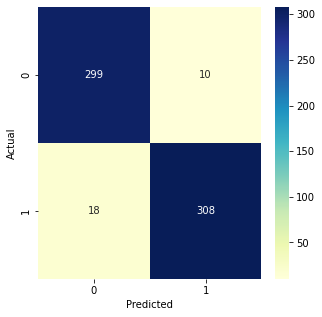

In [29]:
from sklearn.metrics import confusion_matrix
print("                          Support Vector Method")
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap ='YlGnBu',
            xticklabels=category_id_df.label.values, yticklabels=category_id_df.label.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### SVM - Precision, Recall and F1-Score to quantify the quality of our model using a confusion matrix

In [30]:
results = confusion_matrix(y_test, y_pred)
print ('Confusion Matrix :')
print(results) 
print ('Accuracy Score :',accuracy_score(y_test, y_pred))
print ('Report : ')
print (classification_report(y_test, y_pred))

Confusion Matrix :
[[299  10]
 [ 18 308]]
Accuracy Score : 0.9559055118110236
Report : 
              precision    recall  f1-score   support

           0       0.94      0.97      0.96       309
           1       0.97      0.94      0.96       326

    accuracy                           0.96       635
   macro avg       0.96      0.96      0.96       635
weighted avg       0.96      0.96      0.96       635



# SVM - BOW

In [31]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
features1 = count_vect.fit_transform(data.Text_Final).toarray()
labels = data.label
features1.shape

(6341, 61334)

In [32]:
# Using similar split 90/10
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(features1, labels, data.index, test_size=0.10, random_state=72)

In [33]:
# generate Linear SVM model
#model2 = LinearSVC()
model2 = LinearSVC(random_state=0, tol=1e-5, verbose=1, max_iter=10000)
clf2 = model2.fit(X_train, y_train)
y_pred2 = model2.predict(X_test)

[LibLinear].............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

/Users/syedshayanjamal/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


###  SVM - BOW - Displaying false-positive rate (FPR) and true positive rate (TPR)

                     Support Vector Method - BOW


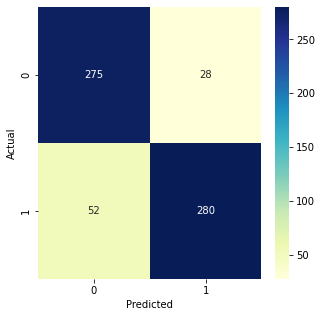

In [34]:
from sklearn.metrics import confusion_matrix
print("                     Support Vector Method - BOW")
conf_mat = confusion_matrix(y_test, y_pred2)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap="YlGnBu",
            xticklabels=category_id_df.label.values, yticklabels=category_id_df.label.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### SVM - BOW - Precision, Recall and F1-Score to quantify the quality of our model using a confusion matrix.

In [35]:
results2 = confusion_matrix(y_test, y_pred2)
print ('Confusion Matrix :')
print(results2) 
print ('Accuracy Score :',accuracy_score(y_test, y_pred2))
print ('Report : ')
print (classification_report(y_test, y_pred2))

Confusion Matrix :
[[275  28]
 [ 52 280]]
Accuracy Score : 0.8740157480314961
Report : 
              precision    recall  f1-score   support

           0       0.84      0.91      0.87       303
           1       0.91      0.84      0.88       332

    accuracy                           0.87       635
   macro avg       0.88      0.88      0.87       635
weighted avg       0.88      0.87      0.87       635



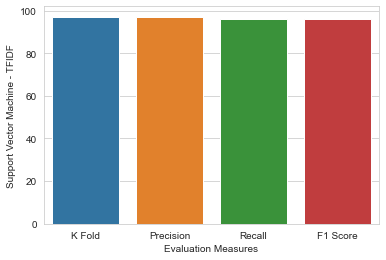

In [36]:
# for tfidf
import pandas as pd
import seaborn as sns
results=pd.DataFrame()
dictionary=dict()
dictionary['Evaluation Measures']=["K Fold", "Precision", "Recall", "F1 Score"]
dictionary['Support Vector Machine - TFIDF']=[97.1, 97, 96, 96]
results=pd.DataFrame(dictionary)
sns.set_style(style="whitegrid")
ax = sns.barplot(x='Evaluation Measures', y= 'Support Vector Machine - TFIDF',data=results)

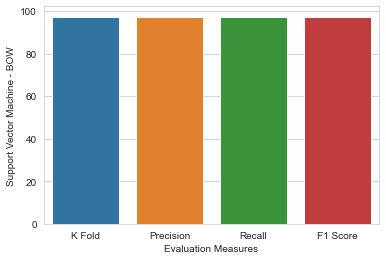

In [37]:
# for BOW
import seaborn as sns
results=pd.DataFrame()
dictionary=dict()
dictionary['Evaluation Measures']=["K Fold", "Precision", "Recall", "F1 Score"]
dictionary['Support Vector Machine - BOW']=[97.3, 97, 97, 97]
results=pd.DataFrame(dictionary)
sns.set_style(style="whitegrid")
ax = sns.barplot(x='Evaluation Measures', y= 'Support Vector Machine - BOW',data=results)